# 1. Problem Definition and Objectives

- Predict whether a patient is at risk of heart disease / stroke (binary classification).
- Dataset is imbalanced (many more “No disease” than “Disease” cases).
- Main goal is to **maximise recall for the disease class** while keeping precision and ROC-AUC reasonable.
- Compare several imbalance-handling strategies:
  - Class weighting (baseline models).
  - SMOTE oversampling (default and gentle).
  - Unsupervised KMeans risk clustering combined with SMOTE + Logistic Regression.
  - Threshold tuning on the final model to explicitly target high recall.

## 2. Data Loading, Target Definition and Preprocessing Pipeline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

plt.style.use('default')
sns.set_palette("husl")

BASE_DIR = Path.cwd()
DATA_PATH = BASE_DIR / 'dataset' / 'heart_disease.csv'

df = pd.read_csv(
    DATA_PATH,
    na_values=['NA', 'na', 'N/A', 'n/a', '']
)

target_col = 'Heart_ stroke'
df['target'] = (df[target_col].str.lower() == 'yes').astype(int)
df = df.drop(columns=[target_col])

numeric_features = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
categorical_features = ['Gender', 'education', 'currentSmoker', 'BPMeds',
                        'prevalentStroke', 'prevalentHyp', 'diabetes']

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("\nClass balance in training set:")
print(y_train.value_counts(normalize=True).rename("proportion"))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Training set shape: (3390, 15)
Test set shape: (848, 15)

Class balance in training set:
target
0    0.848083
1    0.151917
Name: proportion, dtype: float64


## 3. Baseline Models – Class Weighting Only (No SMOTE)

In [4]:
models_baseline = {
    'LR Balanced': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'RF Balanced': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
}

for name, model in models_baseline.items():
    models_baseline[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

results_baseline = {}

for name, pipeline in models_baseline.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    results_baseline[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Pipeline': pipeline,
        'y_prob': y_prob
    }

results_baseline_df = pd.DataFrame(results_baseline).T.drop(columns=['Pipeline', 'y_prob'])
print("\nBLOCK 3 – Baseline (Class Weighting) Performance:")
display(results_baseline_df)

Training LR Balanced...
Training RF Balanced...

BLOCK 3 – Baseline (Class Weighting) Performance:


,Accuracy,Precision,Recall,F1 Score,ROC AUC
LR Balanced,0.667453,0.250814,0.596899,0.353211,0.695443
RF Balanced,0.846698,0.428571,0.023256,0.044118,0.650715


## 4. Handling Class Imbalance with SMOTE (Default and Gentle)

In [5]:
# 4.1 Default SMOTE (full oversampling)

models_smote = {
    'SMOTE + LR': ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'SMOTE + RF': ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
}

results_smote = {}

for name, pipeline in models_smote.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    results_smote[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Pipeline': pipeline,
        'y_prob': y_prob
    }

results_smote_df = pd.DataFrame(results_smote).T.drop(columns=['Pipeline', 'y_prob'])
print("\nBLOCK 4.1 – SMOTE (default) Model Performance:")
display(results_smote_df)

# 4.2 Gentle SMOTE (sampling_strategy = 0.5)

models_gentle = {
    'LR Balanced': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'RF Balanced': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),

    'SMOTE + LR (0.5)': ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(
            sampling_strategy=0.5,
            k_neighbors=5,
            random_state=42
        )),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'SMOTE + RF (0.5)': ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(
            sampling_strategy=0.5,
            k_neighbors=5,
            random_state=42
        )),
        ('classifier', RandomForestClassifier(
            n_estimators=200,
            random_state=42
        ))
    ])
}

for name, model in list(models_gentle.items()):
    if 'SMOTE' not in name:
        models_gentle[name] = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

results_gentle = {}

for name, pipeline in models_gentle.items():
    print(f"\nTraining {name}...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    results_gentle[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Pipeline': pipeline,
        'y_prob': y_prob
    }

results_gentle_df = pd.DataFrame(results_gentle).T.drop(columns=['Pipeline', 'y_prob'])
print("\nBLOCK 4.2 – Gentle SMOTE (sampling_strategy=0.5) Performance:")
display(results_gentle_df)

Training SMOTE + LR...
Training SMOTE + RF...

BLOCK 4.1 – SMOTE (default) Model Performance:


,Accuracy,Precision,Recall,F1 Score,ROC AUC
SMOTE + LR,0.658019,0.247649,0.612403,0.352679,0.690332
SMOTE + RF,0.806604,0.238806,0.124031,0.163265,0.649664



Training LR Balanced...

Training RF Balanced...

Training SMOTE + LR (0.5)...

Training SMOTE + RF (0.5)...

BLOCK 4.2 – Gentle SMOTE (sampling_strategy=0.5) Performance:


,Accuracy,Precision,Recall,F1 Score,ROC AUC
LR Balanced,0.667453,0.250814,0.596899,0.353211,0.695443
RF Balanced,0.846698,0.428571,0.023256,0.044118,0.650715
SMOTE + LR (0.5),0.785377,0.300752,0.310078,0.305344,0.693804
SMOTE + RF (0.5),0.821934,0.238095,0.077519,0.116959,0.64899


## 5. Unsupervised Risk Clustering + SMOTE + Logistic Regression

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

class KMeansRiskCluster(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_features, n_clusters=3, random_state=42):
        self.numeric_features = numeric_features
        self.n_clusters = n_clusters
        self.random_state = random_state

    def fit(self, X, y=None):
        X_num = X[self.numeric_features].copy()
        self.imputer_ = SimpleImputer(strategy='median')
        self.scaler_ = StandardScaler()
        X_num_imputed = self.imputer_.fit_transform(X_num)
        X_num_scaled = self.scaler_.fit_transform(X_num_imputed)
        self.kmeans_ = KMeans(
            n_clusters=self.n_clusters,
            random_state=self.random_state,
            n_init="auto"
        )
        self.kmeans_.fit(X_num_scaled)
        return self

    def transform(self, X):
        X_out = X.copy()
        X_num = X_out[self.numeric_features].copy()
        X_num_imputed = self.imputer_.transform(X_num)
        X_num_scaled = self.scaler_.transform(X_num_imputed)
        clusters = self.kmeans_.predict(X_num_scaled)
        X_out["risk_cluster"] = clusters
        return X_out

categorical_with_cluster = categorical_features + ['risk_cluster']

preprocessor_with_cluster = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_with_cluster)
    ]
)

models_cluster = {
    'Cluster + SMOTE + LR': ImbPipeline(steps=[
        ('cluster', KMeansRiskCluster(
            numeric_features=numeric_features,
            n_clusters=3,
            random_state=42
        )),
        ('preprocessor', preprocessor_with_cluster),
        ('smote', SMOTE(
            sampling_strategy=0.5,
            k_neighbors=5,
            random_state=42
        )),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])
}

results_cluster = {}

for name, pipeline in models_cluster.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    results_cluster[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Pipeline': pipeline,
        'y_prob': y_prob
    }

results_cluster_df = pd.DataFrame(results_cluster).T.drop(columns=['Pipeline', 'y_prob'])
print("\nBLOCK 5 – Cluster + SMOTE + LR Performance:")
display(results_cluster_df)

Training Cluster + SMOTE + LR...

BLOCK 5 – Cluster + SMOTE + LR Performance:


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Cluster + SMOTE + LR,0.784198,0.295455,0.302326,0.298851,0.694181


## 6. Threshold Tuning for Final Model (High Recall Focus)

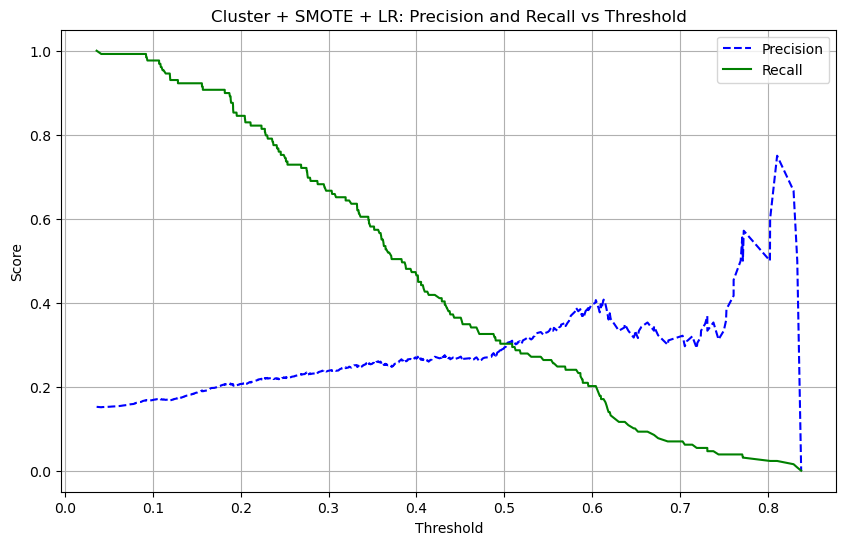

Optimal Threshold for ~80% Recall: 0.2284
Resulting Precision: 0.2191
Resulting Recall   : 0.7984

Confusion Matrix with Optimised Threshold:
[[352 367]
 [ 26 103]]

Classification Report with Optimised Threshold:
              precision    recall  f1-score   support

           0       0.93      0.49      0.64       719
           1       0.22      0.80      0.34       129

    accuracy                           0.54       848
   macro avg       0.58      0.64      0.49       848
weighted avg       0.82      0.54      0.60       848



In [7]:
def plot_precision_recall_vs_threshold(y_true, y_scores, model_name):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title(f"{model_name}: Precision and Recall vs Threshold")
    plt.grid(True)
    plt.show()

final_name = 'Cluster + SMOTE + LR'
y_scores = results_cluster[final_name]['y_prob']

plot_precision_recall_vs_threshold(y_test, y_scores, final_name)

target_recall = 0.80
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
idx = np.argmin(np.abs(recalls - target_recall))

optimal_threshold = thresholds[idx]
optimal_precision = precisions[idx]
optimal_recall = recalls[idx]

print(f"Optimal Threshold for ~{target_recall*100:.0f}% Recall: {optimal_threshold:.4f}")
print(f"Resulting Precision: {optimal_precision:.4f}")
print(f"Resulting Recall   : {optimal_recall:.4f}")

y_pred_new = (y_scores >= optimal_threshold).astype(int)

print("\nConfusion Matrix with Optimised Threshold:")
print(confusion_matrix(y_test, y_pred_new))

print("\nClassification Report with Optimised Threshold:")
print(classification_report(y_test, y_pred_new))

## 6. Hyperparameter Tuning for Final Logistic Regression Pipeline


In [8]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

pipe_to_tune = ImbPipeline(steps=[
    ('cluster', KMeansRiskCluster(
        numeric_features=numeric_features,
        n_clusters=3,
        random_state=42
    )),
    ('preprocessor', preprocessor_with_cluster),
    ('smote', SMOTE(
        sampling_strategy=0.5,
        k_neighbors=5,
        random_state=42
    )),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000
    ))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__penalty': ['l2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe_to_tune,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print("Fitting GridSearchCV on training data...")
grid.fit(X_train, y_train)

print("\nBest parameters:")
print(grid.best_params_)

print("\nBest cross-validated F1 score:")
print(grid.best_score_)

best_lr_pipe = grid.best_estimator_

y_pred_tuned = best_lr_pipe.predict(X_test)
y_prob_tuned = best_lr_pipe.predict_proba(X_test)[:, 1]

results_tuned_lr = {
    'Accuracy': accuracy_score(y_test, y_pred_tuned),
    'Precision': precision_score(y_test, y_pred_tuned),
    'Recall': recall_score(y_test, y_pred_tuned),
    'F1 Score': f1_score(y_test, y_pred_tuned),
    'ROC AUC': roc_auc_score(y_test, y_prob_tuned)
}

print("\nBLOCK 6 – Tuned Cluster + SMOTE + LR Performance on Test Set:")
print(pd.Series(results_tuned_lr))


Fitting GridSearchCV on training data...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters:
{'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2'}

Best cross-validated F1 score:
0.38722747938640906

BLOCK 6 – Tuned Cluster + SMOTE + LR Performance on Test Set:
Accuracy     0.659198
Precision    0.251553
Recall       0.627907
F1 Score     0.359202
ROC AUC      0.694796
dtype: float64


## 7. Threshold Tuning for Tuned Final Model


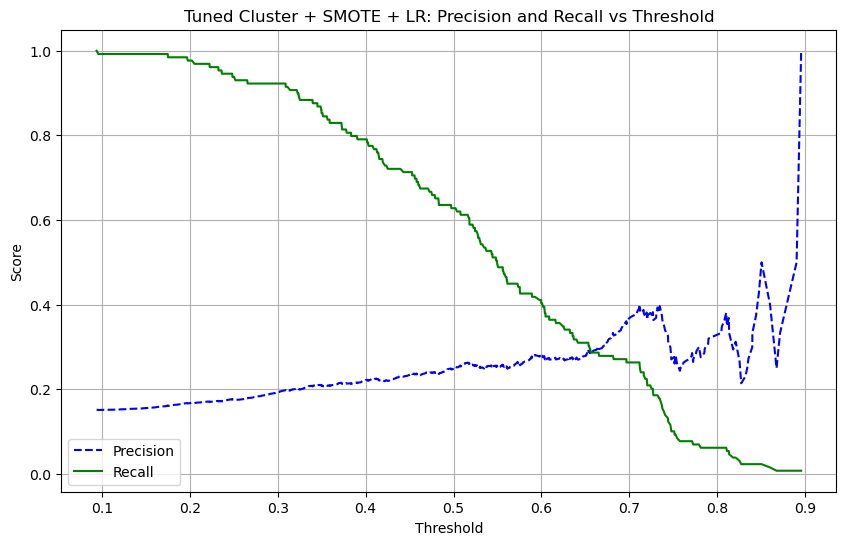

Optimal Threshold for ~80% Recall: 0.3834
Resulting Precision: 0.2128
Resulting Recall   : 0.7984

Confusion Matrix with Optimised Threshold:
[[338 381]
 [ 26 103]]

Classification Report with Optimised Threshold:
              precision    recall  f1-score   support

           0       0.93      0.47      0.62       719
           1       0.21      0.80      0.34       129

    accuracy                           0.52       848
   macro avg       0.57      0.63      0.48       848
weighted avg       0.82      0.52      0.58       848



In [9]:
def plot_precision_recall_vs_threshold(y_true, y_scores, model_name):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title(f"{model_name}: Precision and Recall vs Threshold")
    plt.grid(True)
    plt.show()

y_scores_tuned = best_lr_pipe.predict_proba(X_test)[:, 1]
model_name = 'Tuned Cluster + SMOTE + LR'

plot_precision_recall_vs_threshold(y_test, y_scores_tuned, model_name)

target_recall = 0.80
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_tuned)
idx = np.argmin(np.abs(recalls - target_recall))

optimal_threshold = thresholds[idx]
optimal_precision = precisions[idx]
optimal_recall = recalls[idx]

print(f"Optimal Threshold for ~{target_recall*100:.0f}% Recall: {optimal_threshold:.4f}")
print(f"Resulting Precision: {optimal_precision:.4f}")
print(f"Resulting Recall   : {optimal_recall:.4f}")

y_pred_new = (y_scores_tuned >= optimal_threshold).astype(int)

print("\nConfusion Matrix with Optimised Threshold:")
print(confusion_matrix(y_test, y_pred_new))

print("\nClassification Report with Optimised Threshold:")
print(classification_report(y_test, y_pred_new))


In [11]:
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

models_imb_ensembles = {
    'Balanced RF': ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', BalancedRandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    'EasyEnsemble': ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', EasyEnsembleClassifier(
            n_estimators=10,
            random_state=42,
            n_jobs=-1
        ))
    ])
}

results_imb_ensembles = {}

for name, pipeline in models_imb_ensembles.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    results_imb_ensembles[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob)
    }

results_imb_ensembles_df = pd.DataFrame(results_imb_ensembles).T
print("\nBLOCK 7 – Imbalanced Ensembles Performance:")
display(results_imb_ensembles_df)


Training Balanced RF...


c:\Users\salla\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\salla\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\salla\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Training EasyEnsemble...

BLOCK 7 – Imbalanced Ensembles Performance:


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Balanced RF,0.634434,0.221538,0.558140,0.317181,0.667254
EasyEnsemble,0.637972,0.236686,0.620155,0.342612,0.683373


## 7. Conclusion

- Summarise baseline vs SMOTE vs gentle SMOTE vs cluster-enhanced model in terms of recall, F1-score and ROC-AUC for the disease class.
- Highlight that accuracy is misleading due to strong class imbalance.
- Emphasise that the final selected model (`Cluster + SMOTE + LR` with tuned threshold) is chosen because it achieves substantially higher recall on disease cases while maintaining acceptable precision and ROC-AUC.
- Explain that threshold tuning allows explicitly trading precision for recall, which is appropriate for medical risk screening where missing positive cases is more costly than false alarms.